In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from prophet import Prophet
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/MyDrive/Electric_Consumption.csv', index_col=0, parse_dates=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<ipython-input-174-4df94a6f0e92>:11: DtypeWarning:

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447849 entries, ADAMS to WYCKOFF GARDENS
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Borough             447849 non-null  object 
 1   Account Name        447849 non-null  object 
 2   Location            436128 non-null  object 
 3   Meter AMR           447622 non-null  object 
 4   Meter Scope         23867 non-null   object 
 5   TDS #               445111 non-null  float64
 6   EDP                 447849 non-null  int64  
 7   RC Code             447849 non-null  object 
 8   Funding Source      447849 non-null  object 
 9   AMP #               445962 non-null  object 
 10  Vendor Name         447849 non-null  object 
 11  UMIS BILL ID        447849 non-null  int64  
 12  Revenue Month       447849 non-null  object 
 13  Service Start Date  447841 non-null  object 
 14  Service End Date    447841 non-null  object 
 15  # days              447841

In [ ]:
df.head()

,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,AMP #,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
Development Name,,,,,,,,,,,,,,,,,,,,,
ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,...,7223256,N,15396.82,GOV/NYC/068,Yes,128800.0,7387.97,216.0,2808.0,5200.85
ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,...,7223256,N,14556.34,GOV/NYC/068,Yes,115200.0,6607.87,224.0,2912.0,5036.47
ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,...,7223256,N,13904.98,GOV/NYC/068,Yes,103200.0,5919.55,216.0,2808.0,5177.43
ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,...,7223256,N,14764.04,GOV/NYC/068,Yes,105600.0,6057.22,208.0,2704.0,6002.82
ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,NY005001180P,...,7223256,N,13729.54,GOV/NYC/068,Yes,97600.0,5598.34,216.0,2808.0,5323.20


In [ ]:
#compute mid-point between service start date and service end date
df['Date'] = pd.to_datetime((pd.to_datetime(df['Service Start Date']) +
                            pd.to_timedelta(df['# days'] // 2, unit='d')).dt.date)

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

#relevant columns
df_consumption = df[['Consumption (KWH)', 'Consumption (KW)']]
print(df_consumption)

# Read in the dataframe
df = df_consumption

# Calculate the time interval between consecutive observations
time_interval = df.index[1] - df.index[0]

# Print the time interval and the unit of time
print(f'Time interval: {time_interval}')
print(f'Unit of time: {time_interval.components[0]}')

            Consumption (KWH)  Consumption (KW)
Date                                           
2010-01-09           128800.0            216.00
2010-02-10           115200.0            224.00
2010-03-11           103200.0            216.00
2010-04-10           105600.0            208.00
2010-05-10            97600.0            216.00
...                       ...               ...
2023-01-08                0.0            144.60
2023-01-08                0.0            162.48
2023-01-08            82800.0              0.00
2023-01-08            90400.0              0.00
2023-01-08            98400.0              0.00

[447849 rows x 2 columns]
Time interval: 32 days 00:00:00
Unit of time: 32


In [ ]:
# Average daily, monthly, yearly
df_daily = df_consumption.resample('D').mean()
df_monthly = df_consumption.resample('M').mean()
df_yearly = df_consumption.resample('Y').mean()

print(df_daily)
print(df_monthly)
print(df_yearly)

            Consumption (KWH)  Consumption (KW)
Date                                           
2010-01-03                6.6             0.000
2010-01-04                NaN               NaN
2010-01-05                NaN               NaN
2010-01-06                NaN               NaN
2010-01-07                NaN               NaN
...                       ...               ...
2023-06-04                NaN               NaN
2023-06-05                NaN               NaN
2023-06-06                NaN               NaN
2023-06-07                NaN               NaN
2023-06-08            54054.0           103.965

[4905 rows x 2 columns]
            Consumption (KWH)  Consumption (KW)
Date                                           
2010-01-31       45446.030782         75.733258
2010-02-28       38808.144583         70.191838
2010-03-31       36667.210941         70.130837
2010-04-30       36808.514463         71.063694
2010-05-31       36933.632880         81.022950
...            

In [ ]:
print(df_daily.isnull().sum())
df_daily.shape

Consumption (KWH)    3895
Consumption (KW)     3895
dtype: int64


(4905, 2)

In [ ]:
print(df_monthly.isnull().sum())

Consumption (KWH)    27
Consumption (KW)     27
dtype: int64


In [ ]:
print(df_daily)

            Consumption (KWH)  Consumption (KW)
Date                                           
2010-01-03                6.6             0.000
2010-01-04                NaN               NaN
2010-01-05                NaN               NaN
2010-01-06                NaN               NaN
2010-01-07                NaN               NaN
...                       ...               ...
2023-06-04                NaN               NaN
2023-06-05                NaN               NaN
2023-06-06                NaN               NaN
2023-06-07                NaN               NaN
2023-06-08            54054.0           103.965

[4905 rows x 2 columns]


In [ ]:
# Get the mean consumption for each year
yearly_mean = df_daily.groupby(df_daily.index.year)['Consumption (KWH)'].mean()
print(yearly_mean)

Date
2010     74161.456314
2011              NaN
2012     52142.373781
2013     81427.589731
2014    106895.073369
2015    106685.192598
2016     78200.315262
2017     80917.499734
2018      9120.000000
2019     65655.827382
2020     74620.025650
2021     53647.849882
2022     57479.050414
2023     90922.558144
Name: Consumption (KWH), dtype: float64


In [ ]:
# fill null values with median of previous month
df_daily_fill = df_daily.fillna(method='ffill').fillna(df_daily.groupby(df_daily.index.to_period('Y')).transform('median').fillna(method='bfill'))
df_monthly_fill = df_monthly.fillna(method='ffill').fillna(df_monthly.groupby(df_monthly.index.to_period('Y')).transform('median').fillna(method='bfill'))
df_yearly_fill = df_yearly.fillna(method='ffill').fillna(df_yearly.groupby(df_yearly.index.to_period('Y')).transform('median').fillna(method='bfill'))
print(df_monthly_fill)

            Consumption (KWH)  Consumption (KW)
Date                                           
2010-01-31       45446.030782         75.733258
2010-02-28       38808.144583         70.191838
2010-03-31       36667.210941         70.130837
2010-04-30       36808.514463         71.063694
2010-05-31       36933.632880         81.022950
...                       ...               ...
2023-02-28       29222.102459         50.491893
2023-03-31       29222.102459         50.491893
2023-04-30       29222.102459         50.491893
2023-05-31       29222.102459         50.491893
2023-06-30       54054.000000        103.965000

[162 rows x 2 columns]


In [ ]:
print(df_daily_fill.isnull().sum())
df_daily_fill.shape

Consumption (KWH)    0
Consumption (KW)     0
dtype: int64


(4905, 2)

In [ ]:
df_monthly_fill.shape

(162, 2)

In [ ]:
df_yearly_fill.shape

(14, 2)

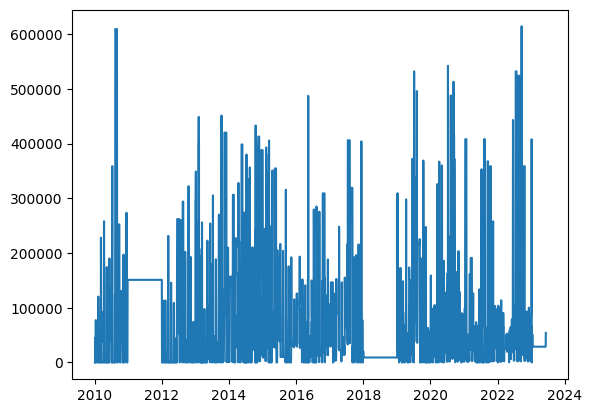

In [ ]:
plt.plot(df_daily_fill['Consumption (KWH)'])

In [ ]:
consumption = df_daily_fill['Consumption (KWH)']
cap=np.percentile(consumption, 95)
print(cap)
floor = np.percentile(consumption, 5)
print(floor)

350400.0
6.6


4905

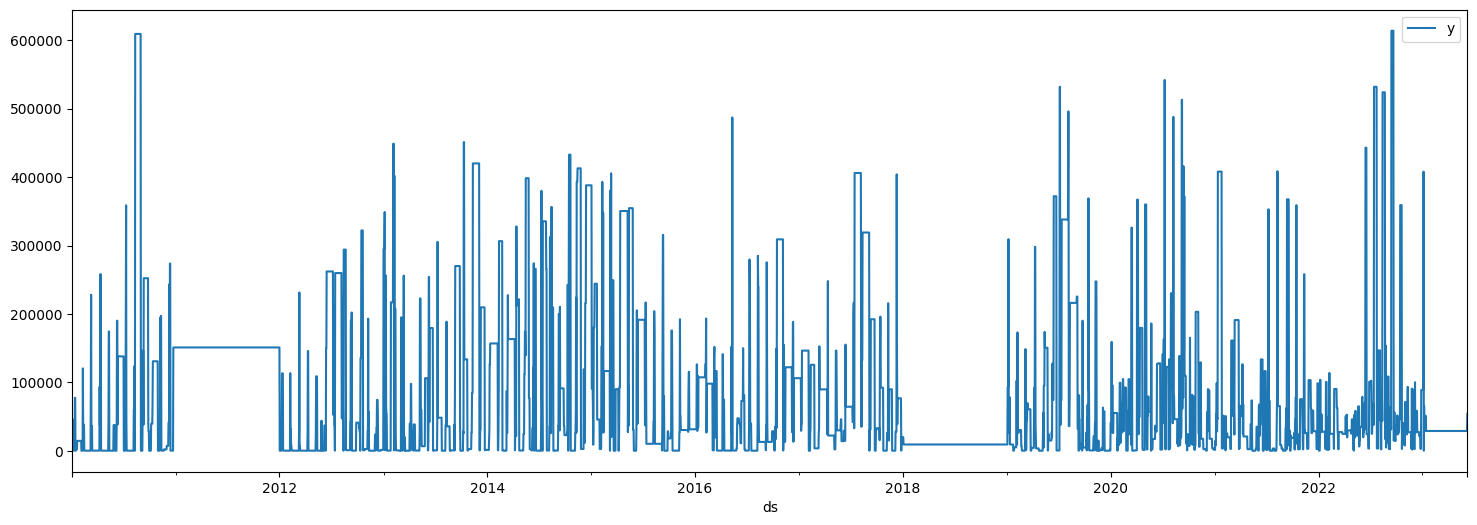

In [ ]:
#Daily
# Convert dataframe to Prophet format for daily data
df_prophet_daily = pd.DataFrame({'ds': df_daily_fill.index, 'y': df_daily_fill['Consumption (KWH)'] })
df_prophet_daily['cap']=350400.0
df_prophet_daily['floor']=6.6
df_prophet_daily.plot(x='ds',y='y',figsize=(18,6))
len(df_prophet_daily)

In [ ]:
#Train Daily Model
model_daily = Prophet()
model_daily.fit(df_prophet_daily)

forecast_periods = [100, 200, 365]
#Predict Daily Model
for period in forecast_periods:
    future = model_daily.make_future_dataframe(periods=period, freq='D')
    forecast = model_daily.predict(future)
    print(f'Daily forecast for {period} days:')
    print(forecast[['ds', 'yhat']].tail(period))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4qivbe6/_34tyrgr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4qivbe6/b8hjqxng.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62920', 'data', 'file=/tmp/tmp_4qivbe6/_34tyrgr.json', 'init=/tmp/tmp_4qivbe6/b8hjqxng.json', 'output', 'file=/tmp/tmp_4qivbe6/prophet_model11rr6c5n/prophet_model-20230505223708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:37:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:37:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Daily forecast for 100 days:
             ds           yhat
4905 2023-06-09   66276.273938
4906 2023-06-10   70267.479744
4907 2023-06-11   73927.158694
4908 2023-06-12   76695.194459
4909 2023-06-13   79055.923905
...         ...            ...
5000 2023-09-12  103953.897498
5001 2023-09-13   99888.291695
5002 2023-09-14   97003.528412
5003 2023-09-15   95623.159684
5004 2023-09-16   94150.239959

[100 rows x 2 columns]
Daily forecast for 200 days:
             ds          yhat
4905 2023-06-09  66276.273938
4906 2023-06-10  70267.479744
4907 2023-06-11  73927.158694
4908 2023-06-12  76695.194459
4909 2023-06-13  79055.923905
...         ...           ...
5100 2023-12-21  66193.377794
5101 2023-12-22  68160.687547
5102 2023-12-23  70191.370167
5103 2023-12-24  71743.549707
5104 2023-12-25  72282.380364

[200 rows x 2 columns]
Daily forecast for 365 days:
             ds          yhat
4905 2023-06-09  66276.273938
4906 2023-06-10  70267.479744
4907 2023-06-11  73927.158694
4908 2023-06-

In [ ]:
#Evaluation
df_eval = pd.concat([df_prophet_daily.set_index('ds'), forecast.set_index('ds')['yhat']], axis=1, join='inner')
y_true = df_eval['y'].values
y_pred = df_eval['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"R^2: {r2:.2f}")

MAE: 81704.76
MAPE: 1505963015708181004288.00%
R^2: 0.07


In [ ]:
plot_plotly(model_daily, forecast)

We can see the electricity usage spiking in July and August of each year. People are likely using more electricity for cooling systems in the summer.


Black dots represent the actual values, Blue line represents the predictions, light blue shaded region is the upper and lower bound for yhat

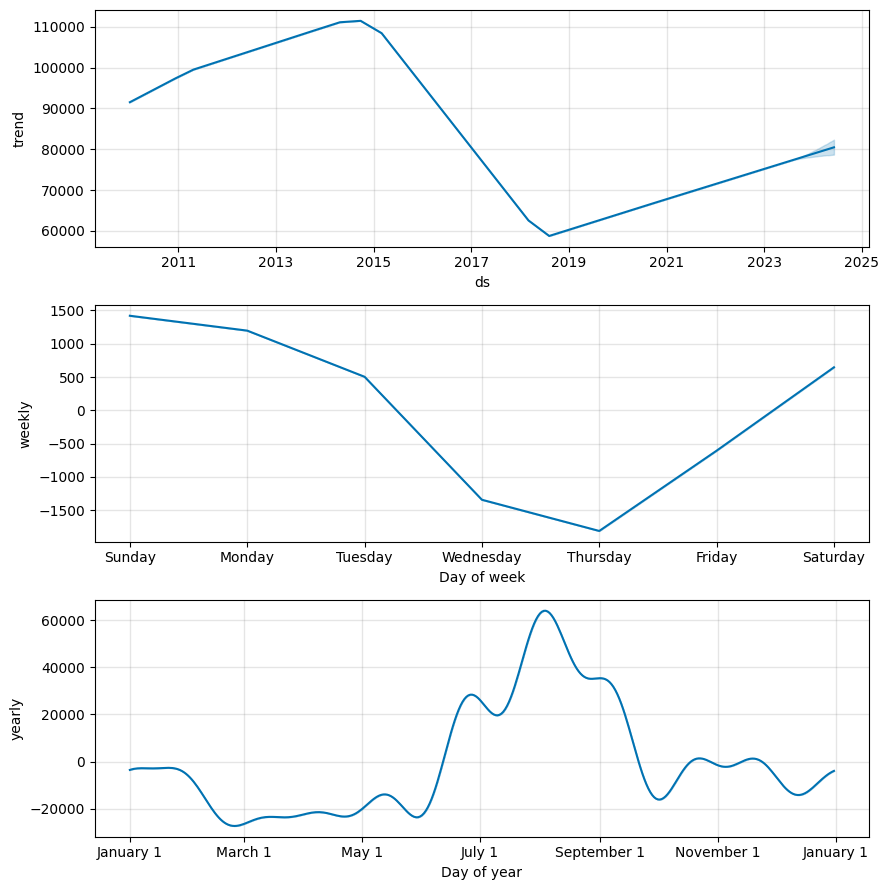

In [ ]:
plot = model_daily.plot_components(forecast)

When we plot the model, we can see a curve showing a point of saturation. This indicates we set the growth parameter to logistic.

Shows spikes in usage on Sunday each week and dips on Thursdays, and August of each year.


In [ ]:
#Tune daily model
prophet_daily = Prophet(
    growth="logistic",
    seasonality_mode="additive",
    changepoint_prior_scale=35,
    seasonality_prior_scale=25,
    daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False
    ).add_seasonality(name="yearly", period=365.25, fourier_order=10
    ).add_seasonality(name="weekly", period=7, fourier_order=10
    )

prophet_daily.fit(df_prophet_daily)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4qivbe6/pafpg2eb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4qivbe6/fmy6u9gv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22937', 'data', 'file=/tmp/tmp_4qivbe6/pafpg2eb.json', 'init=/tmp/tmp_4qivbe6/fmy6u9gv.json', 'output', 'file=/tmp/tmp_4qivbe6/prophet_modeluwqnvn3l/prophet_model-20230505223728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:37:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:37:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast_periods = [100, 200, 365]
#Predict Daily Model
for period in forecast_periods:
    future = prophet_daily.make_future_dataframe(periods=period, freq='D')
    future['cap'] = cap
    future['floor'] = floor
    forecast = prophet_daily.predict(future)
    print(f'Daily forecast for {period} days:')
    print(forecast[['ds', 'yhat']].tail(period))



Daily forecast for 100 days:
             ds          yhat
4905 2023-06-09  54710.140679
4906 2023-06-10  58684.054807
4907 2023-06-11  62349.046121
4908 2023-06-12  65100.592747
4909 2023-06-13  67444.569645
...         ...           ...
5000 2023-09-12  92930.156792
5001 2023-09-13  88860.439686
5002 2023-09-14  85970.000938
5003 2023-09-15  84560.610773
5004 2023-09-16  83077.230603

[100 rows x 2 columns]
Daily forecast for 200 days:
             ds          yhat
4905 2023-06-09  54710.140679
4906 2023-06-10  58684.054807
4907 2023-06-11  62349.046121
4908 2023-06-12  65100.592747
4909 2023-06-13  67444.569645
...         ...           ...
5100 2023-12-21  51066.375385
5101 2023-12-22  52994.079518
5102 2023-12-23  55010.837590
5103 2023-12-24  56578.262607
5104 2023-12-25  57116.327554

[200 rows x 2 columns]
Daily forecast for 365 days:
             ds          yhat
4905 2023-06-09  54710.140679
4906 2023-06-10  58684.054807
4907 2023-06-11  62349.046121
4908 2023-06-12  65100.59

In [ ]:
df_eval = pd.concat([df_prophet_daily.set_index('ds'), forecast.set_index('ds')['yhat']], axis=1, join='inner')
y_true = df_eval['y'].values
y_pred = df_eval['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"R^2: {r2:.2f}")

MAE: 76556.36
MAPE: 1497809362162906038272.00%
R^2: 0.12


In [ ]:
plot_plotly(prophet_daily, forecast)

In [ ]:
changepoints = prophet_daily.changepoints
print(changepoints)

157    2010-06-09
314    2010-11-13
471    2011-04-19
628    2011-09-23
785    2012-02-27
942    2012-08-02
1098   2013-01-05
1255   2013-06-11
1412   2013-11-15
1569   2014-04-21
1726   2014-09-25
1883   2015-03-01
2040   2015-08-05
2197   2016-01-09
2354   2016-06-14
2511   2016-11-18
2668   2017-04-24
2825   2017-09-28
2981   2018-03-03
3138   2018-08-07
3295   2019-01-11
3452   2019-06-17
3609   2019-11-21
3766   2020-04-26
3923   2020-09-30
Name: ds, dtype: datetime64[ns]


In [ ]:
consumption = df_monthly_fill['Consumption (KWH)']
cap=np.percentile(consumption, 95)
print(cap)
floor = np.percentile(consumption, 5)
print(floor)

45330.68042181671
9120.0


162

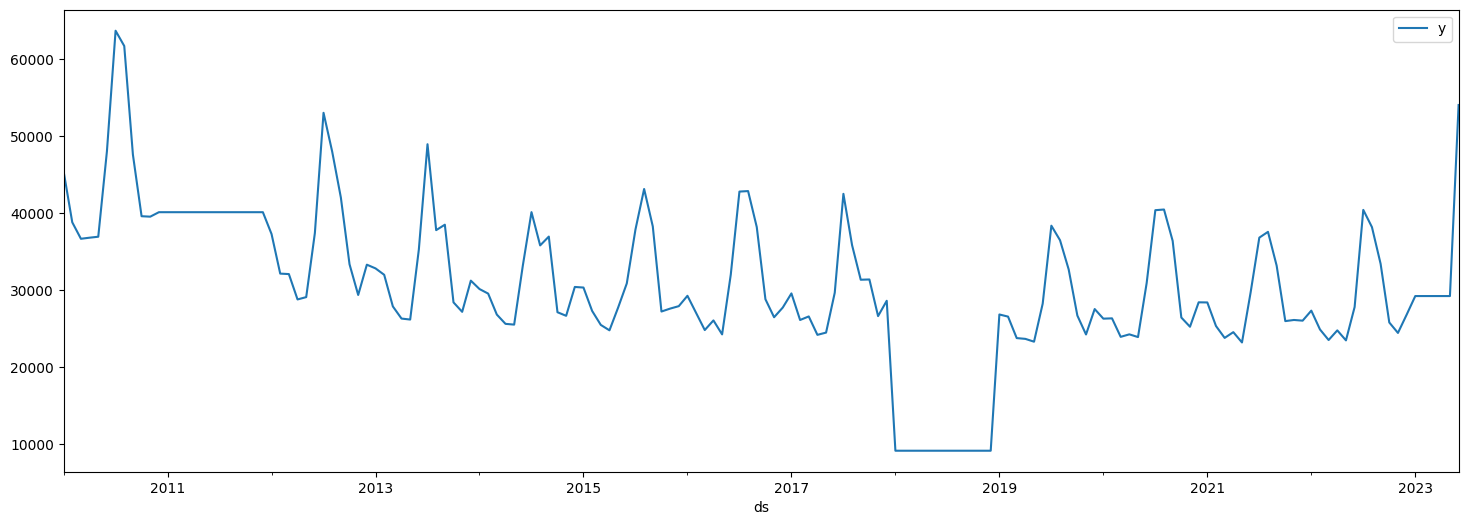

In [ ]:
#monthly
# Convert dataframe to Prophet format for monthly data
df_prophet_monthly = pd.DataFrame({'ds': df_monthly_fill.index, 'y': df_monthly_fill['Consumption (KWH)']})
df_prophet_monthly['cap']=45330.68
df_prophet_monthly['floor']=9120.0
df_prophet_monthly.plot(x='ds',y='y',figsize=(18,6))
len(df_prophet_monthly)

In [ ]:
#Train monthly Model
model_monthly = Prophet()
model_monthly.fit(df_prophet_monthly)

forecast_periods = [1, 6, 9]
#Predict monthly Model
for period in forecast_periods:
    future = model_monthly.make_future_dataframe(periods=period, freq='M')
    forecast = model_monthly.predict(future)
    print(f'Monthly forecast for {period} months:')
    print(forecast[['ds', 'yhat']].tail(period))


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4qivbe6/ja76xhd6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4qivbe6/4zg5ca2t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82186', 'data', 'file=/tmp/tmp_4qivbe6/ja76xhd6.json', 'init=/tmp/tmp_4qivbe6/4zg5ca2t.json', 'output', 'file=/tmp/tmp_4qivbe6/prophet_modelbckck9md/prophet_model-20230505223838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:38:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:38:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Monthly forecast for 1 months:
            ds          yhat
162 2023-07-31  41374.645389
Monthly forecast for 6 months:
            ds          yhat
162 2023-07-31  41374.645389
163 2023-08-31  40128.342043
164 2023-09-30  36816.156671
165 2023-10-31  30690.277168
166 2023-11-30  29810.584146
167 2023-12-31  31457.444168
Monthly forecast for 9 months:
            ds          yhat
162 2023-07-31  41374.645389
163 2023-08-31  40128.342043
164 2023-09-30  36816.156671
165 2023-10-31  30690.277168
166 2023-11-30  29810.584146
167 2023-12-31  31457.444168
168 2024-01-31  32008.893658
169 2024-02-29  30604.514723
170 2024-03-31  29233.073177


In [ ]:
#Evaluation
df_eval = pd.concat([df_prophet_monthly.set_index('ds'), forecast.set_index('ds')['yhat']], axis=1, join='inner')
y_true = df_eval['y'].values
y_pred = df_eval['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"R^2: {r2:.2f}")

MAE: 3682.38
MAPE: 19.72%
R^2: 0.67


In [ ]:
plot_plotly(model_monthly, forecast)

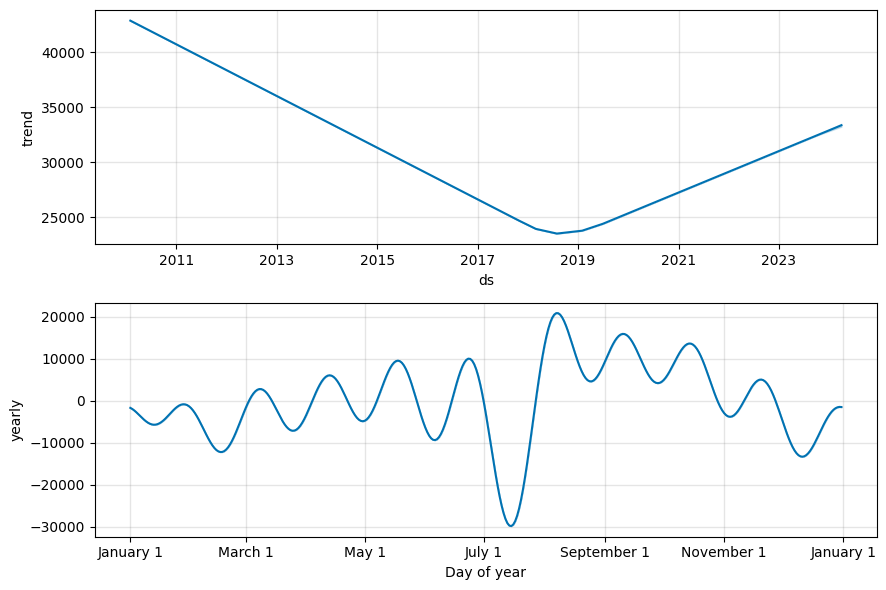

In [ ]:
plot = model_monthly.plot_components(forecast)

In [ ]:
#Tune monthly model
prophet_monthly = Prophet(
    growth="logistic",
    seasonality_mode="additive",
    changepoint_prior_scale=30,
    seasonality_prior_scale=25,
    daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False
    ).add_seasonality(name="yearly", period=365.25, fourier_order=10
    )

prophet_monthly.fit(df_prophet_monthly)

forecast_periods = [1, 6, 9]
#Predict monthly Model
for period in forecast_periods:
    future =prophet_monthly.make_future_dataframe(periods=period, freq='M')
    future['cap'] = cap
    future['floor'] = floor
    forecast = prophet_monthly.predict(future)
    print(f'Monthly forecast for {period} months:')
    print(forecast[['ds', 'yhat']].tail(period))

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4qivbe6/565ld1m2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4qivbe6/jpbogp9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71487', 'data', 'file=/tmp/tmp_4qivbe6/565ld1m2.json', 'init=/tmp/tmp_4qivbe6/jpbogp9q.json', 'output', 'file=/tmp/tmp_4qivbe6/prophet_model65lxw4ja/prophet_model-20230505223856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:38:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:38:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Monthly forecast for 1 months:
            ds          yhat
162 2023-07-31  39656.141431
Monthly forecast for 6 months:
            ds          yhat
162 2023-07-31  39656.141431
163 2023-08-31  40252.296620
164 2023-09-30  36940.742239
165 2023-10-31  31806.983861
166 2023-11-30  30596.310079
167 2023-12-31  31314.114303
Monthly forecast for 9 months:
            ds          yhat
162 2023-07-31  39656.141431
163 2023-08-31  40252.296620
164 2023-09-30  36940.742239
165 2023-10-31  31806.983861
166 2023-11-30  30596.310079
167 2023-12-31  31314.114303
168 2024-01-31  32106.121629
169 2024-02-29  31274.650063
170 2024-03-31  29307.983577


In [ ]:
#Evaluation
df_eval = pd.concat([df_prophet_monthly.set_index('ds'), forecast.set_index('ds')['yhat']], axis=1, join='inner')
y_true = df_eval['y'].values
y_pred = df_eval['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"R^2: {r2:.2f}")

MAE: 2416.52
MAPE: 10.32%
R^2: 0.87


The prophet model performs much better after tuning the model with seasonality and logistic growth parameter.

In [ ]:
consumption = df_yearly_fill['Consumption (KWH)']
cap=np.percentile(consumption, 95)
print(cap)
floor = np.percentile(consumption, 5)
print(floor)

44612.13779554462
21500.69085735805


14

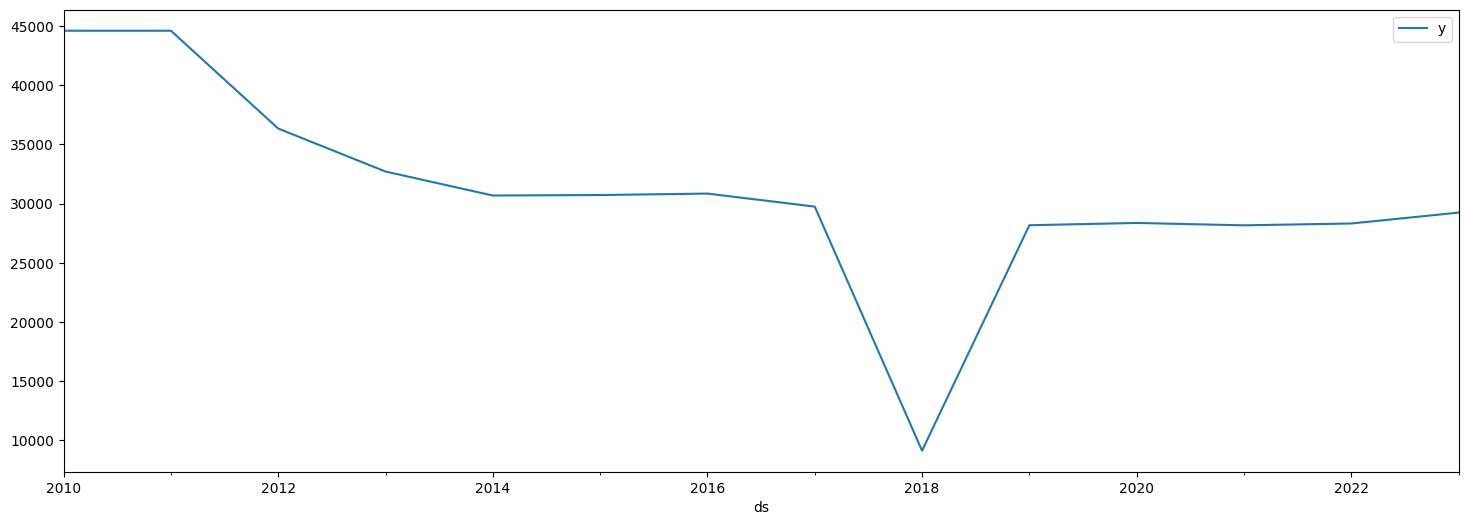

In [ ]:
#Yearly
# Convert dataframe to Prophet format for yearly data
df_prophet_yearly = pd.DataFrame({'ds': df_yearly_fill.index, 'y': df_yearly_fill['Consumption (KWH)']})
df_prophet_yearly['cap']=44612.13779554462
df_prophet_yearly['floor']=21500.69085735805
df_prophet_yearly.plot(x='ds',y='y',figsize=(18,6))

len(df_prophet_yearly)

In [ ]:
#Train Yearly Model
model_yearly = Prophet()
model_yearly.fit(df_prophet_yearly)

forecast_periods = [1, 10, 20]
#Predict Yearly Model
for period in forecast_periods:
    future = model_yearly.make_future_dataframe(periods=period, freq='D')
    forecast = model_yearly.predict(future)
    print(f'Yearly forecast for {period} years:')
    print(forecast)
    print(forecast[['ds', 'yhat']].tail(period))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4qivbe6/flg00rmg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4qivbe6/_8u7zzpe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4690', 'data', 'file=/tmp/tmp_4qivbe6/flg00rmg.json', 'init=/tmp/tmp_4qivbe6/_8u7zzpe.json', 'output', 'file=/tmp/tmp_4qivbe6/prophet_modelv0_mdntl/prophet_model-20230505223938.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:39:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:39:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

Yearly forecast for 1 years:
           ds         trend    yhat_lower    yhat_upper   trend_lower  \
0  2010-12-31  11562.930771  30379.645505  47168.164252  11562.930771   
1  2011-12-31  10323.863926  29649.984938  46191.855339  10323.863926   
2  2012-12-31   9081.402375  27526.799308  43764.844798   9081.402375   
3  2013-12-31   7842.335526  26128.963263  42687.502572   7842.335526   
4  2014-12-31   6603.268677  25930.267433  42364.134810   6603.268677   
5  2015-12-31   5364.201831  26167.488890  41652.919808   5364.201831   
6  2016-12-31   4121.740283  22509.860012  38736.228474   4121.740283   
7  2017-12-31   2882.673438  21848.129679  37505.791426   2882.673438   
8  2018-12-31   1643.606593  20881.167815  37375.126398   1643.606593   
9  2019-12-31    404.539746  20478.888020  36359.698910    404.539746   
10 2020-12-31   -837.921804  17564.360774  33753.248218   -837.921804   
11 2021-12-31  -2076.988648  17062.125396  33285.692148  -2076.988648   
12 2022-12-31  -3316.0

In [ ]:
df_eval = pd.concat([df_prophet_yearly.set_index('ds'), forecast.set_index('ds')['yhat']], axis=1, join='inner')
y_true = df_eval['y'].values
y_pred = df_eval['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"R^2: {r2:.2f}")

MAE: 4072.97
MAPE: 23.59%
R^2: 0.39


In [ ]:
plot_plotly(model_yearly, forecast)

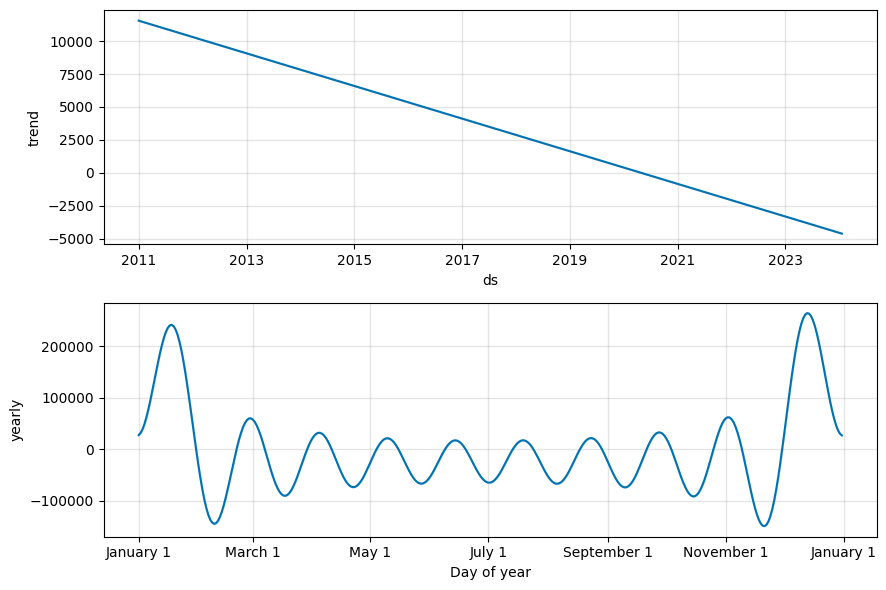

In [ ]:
plot = model_yearly.plot_components(forecast)

In [ ]:
#Tune Yearly Model
prophet_yearly = Prophet(
    growth="logistic",
    seasonality_mode="additive",
    changepoint_prior_scale=30,
    seasonality_prior_scale=35,
    daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False
    ).add_seasonality(name="yearly", period=365.25, fourier_order=10
    )

prophet_yearly.fit(df_prophet_yearly)

forecast_periods = [1, 10, 20]
#Predict Yearly Model
for period in forecast_periods:
    future = prophet_yearly.make_future_dataframe(periods=period, freq='D')
    future['cap'] = cap
    future['floor'] = floor
    forecast = prophet_yearly.predict(future)
    print(f'Yearly forecast for {period} years:')
    print(forecast)
    print(forecast[['ds', 'yhat']].tail(period))

INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4qivbe6/h4u7vayd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_4qivbe6/o7dfy4l2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66003', 'data', 'file=/tmp/tmp_4qivbe6/h4u7vayd.json', 'init=/tmp/tmp_4qivbe6/o7dfy4l2.json', 'output', 'file=/tmp/tmp_4qivbe6/prophet_modela452t61u/prophet_model-20230505224016.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:40:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:40:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Yearly forecast for 1 years:
           ds         trend           cap         floor    yhat_lower  \
0  2010-12-31  43847.234868  44612.137796  21500.690857  35285.378968   
1  2011-12-31  43931.412585  44612.137796  21500.690857  37298.915303   
2  2012-12-31  42534.305741  44612.137796  21500.690857  32678.790658   
3  2013-12-31  39002.381227  44612.137796  21500.690857  29049.187380   
4  2014-12-31  35025.876535  44612.137796  21500.690857  26204.467199   
5  2015-12-31  34795.298038  44612.137796  21500.690857  28251.777520   
6  2016-12-31  34725.435253  44612.137796  21500.690857  25022.809119   
7  2017-12-31  33511.449719  44612.137796  21500.690857  23719.761123   
8  2018-12-31  23509.664190  44612.137796  21500.690857  15208.253429   
9  2019-12-31  28766.698789  44612.137796  21500.690857  21874.368857   
10 2020-12-31  33809.464280  44612.137796  21500.690857  23953.426510   
11 2021-12-31  33227.922258  44612.137796  21500.690857  23533.485611   
12 2022-12-31  32645.5

In [ ]:
df_eval = pd.concat([df_prophet_yearly.set_index('ds'), forecast.set_index('ds')['yhat']], axis=1, join='inner')
y_true = df_eval['y'].values
y_pred = df_eval['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"R^2: {r2:.2f}")

MAE: 1954.24
MAPE: 11.32%
R^2: 0.84


The model significantly improves after tuning the model.